# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>

## Линейная регрессия

В данном ноутбуке мы рассмотрим несложный пример построения модели линейной регрессии, а также предварительной обработки данных. Для построения моделей и методов обработки данных будем использовать широко известную библиотеку <a target="_blank" href="https://scikit-learn.org/">Scikit-Learn</a> (сокращенно `sklearn`), в которой в удобной форме реализованы многие методы машинного обучения и анализа данных в целом. Более того, принятый интерфейс библиотеки часто используют разработчики других библиотек в силу удобства его использования.

Поставить библиотеку можно командой `pip install scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

# обратите внимание, что Scikit-Learn импортируется как sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

### 1. Постановка задачи

Рассмотрим <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/insurance_miptstats.csv" download="insurance_miptstats.csv" >данные</a> медицинского страхования. В каждой строке представлены признаки для каждого клиента страховой организации.

В данных содержатся следующие признаки:
* `birthday` &mdash; день рождения (*в версии Физтех.Статистики; в оригинальной версии `age` &mdash; возраст*);
* `sex` &mdash; пол, возможные значения: `female`, `male`;
* `bmi`  &mdash; соотношение массы тела квадрату его высоты (body mass index), измеряется в кг/м$^2$, хорошие значения лежат в диапазоне от 18.5 до 24.9;
* `children` &mdash; количество детей;
* `smoker` &mdash; курит ли клиент;
* `region` &mdash; район в США, возможные значения: `northeast`, `southeast`, `southwest`, `northwest`;
* `charges` &mdash; индивидуальные медицинские расходы, оплачиваемые медицинским страхованием.

**Задача:** предсказать *индивидуальные медицинские расходы* по остальным признакам.

Оригинальные данные можно посмотреть на <a target="_blank" href="https://www.kaggle.com/mirichoi0218/insurance">Kaggle</a>.

Загрузим данные

In [2]:
data = pd.read_csv('./insurance_miptstats.csv', parse_dates=[0])
data.head()

,birthday,sex,bmi,children,smoker,region,charges
0,2001-12-20,female,27.900,0,yes,southwest,16884.92400
1,2003-03-18,male,33.770,1,no,southeast,1725.55230
2,1992-11-02,male,33.000,3,no,southeast,4449.46200
3,1987-07-27,male,22.705,0,no,northwest,21984.47061
4,1988-11-04,male,28.880,0,no,northwest,3866.85520


Посмотрим на размер таблицы

In [3]:
data.shape

(1338, 7)

Тестировать качество построенной модели всегда нужно на данных, которые не участвовали в обучении. Такие данные называются *тестовыми*. Данные, которые участвуют в обучении, называются *обучающими*.

Выполнить **разбиение на обучающие и тестовые данные** можно с помощью функции <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">`train_test_split`</a>, которая имеет следующий синтаксис:

`sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)`

**Аргументы:**

- `*arrays` &mdash; входные данные, которые должны быть разделены. Можно передавать несколько объектов.
- `test_size` &mdash; размер тестовых данных, может быть задан как в относительных единицах от общего объема данных, тогда значение в диапазоне от 0 до 1, так и в количественных, то есть количество объектов. Если не указан, то дополняет `train_size`, если о он не указан, то принимается значение 0.25.
- `train_size` &mdash; размер тестовых данных, может быть задан как в относительных единицах от общего объема данных, тогда значение в диапазоне от 0 до 1, так и в количественных, то есть количество объектов. Если не указан, то дополняет `test_size`.
- `random_state` &mdash; можно указать для воспроизводимости экспериментов.
- `shuffle` &mdash; перемешивать ли выборку. Если `False`, то аргумент `stratify` должен быть установлен в None.
- `stratify` &mdash; если задан, то метод разбивает на трейн и тест так, чтобы отношение данных разных классов в подвыборках было одинаковым.

Применим эту функцию к нашим данным, отнеся в тестовую часть 20% данных, а в обучающую &mdash; остальные 80%. Поскольку мы использовали параметры по умолчанию, то исходные данные сначала были перемешаны, а затем разделены.

In [4]:
train, test = train_test_split(data, test_size=0.2)
train.shape, test.shape

((1070, 7), (268, 7))

### 2. Обучение

Сразу приведем временной признак, а именно, построим из него признак, отвечающий за возраст человека. Дробные значения отбрасывать смысла нет. При выполнении преобразования учитываем, <a href="https://mipt-stats.gitlab.io/courses/python/08_pandas1.html#5.-Интервалы-времени">как в `pandas` можно работать с интервалами времени</a>.

*Примечание.* Данную операцию можно было выполнить сразу для всех данных. Но лучше так не делать, поскольку в других примерах таким способом иногда можно "подглядеть" в тестовые данные.

In [5]:
train['age'] = (pd.Timestamp('2021-04-17') - train['birthday']) / pd.Timedelta('1Y')

Выделим категории признаков

In [6]:
categorial_features = ['sex', 'smoker', 'region']  # категориальные признаки
real_features = ['age', 'bmi', 'children']  # вещественные признаки
target_feature = 'charges'  # целевой признак

Посмотрим на визуализацию совместных распределений вещественных признаков при помощи <a href="https://mipt-stats.gitlab.io/courses/python/09_seaborn.html#6.-PairGrid">`PairGrid`</a>, причем будем разбивать данные по одному признаку из числа категориальных. На графиках приведены:
* данные в виде точек для каждой пары вещественных признаков;
* ядерные оценки плотности для каждой пары вещественных признаков;
* ядерные оценки плотности для всех вещественных признаков по отдельности.

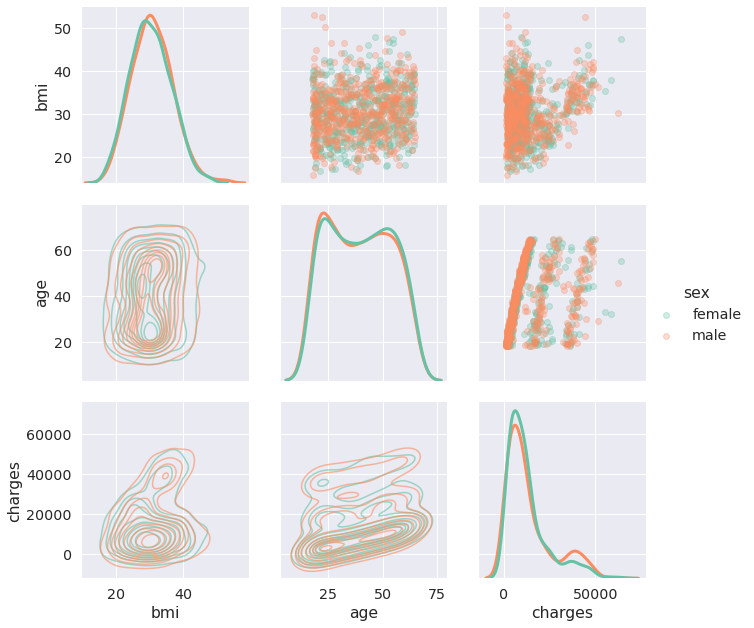

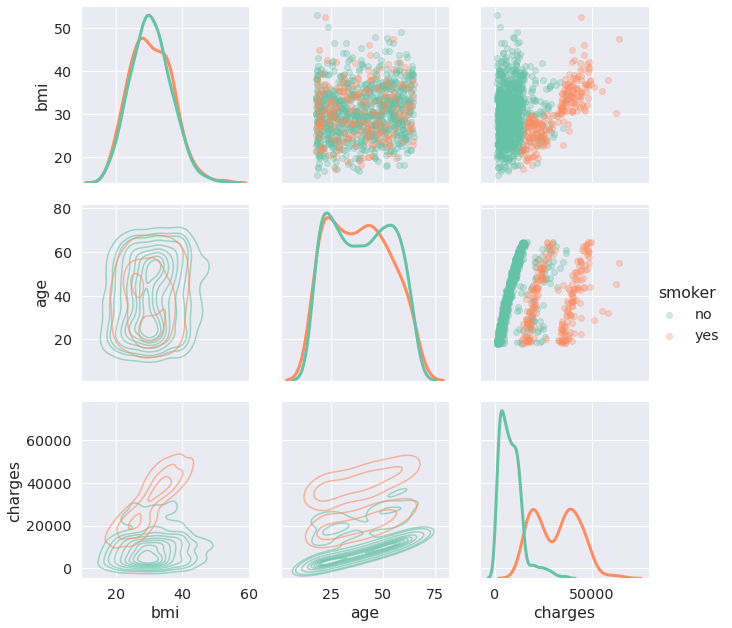

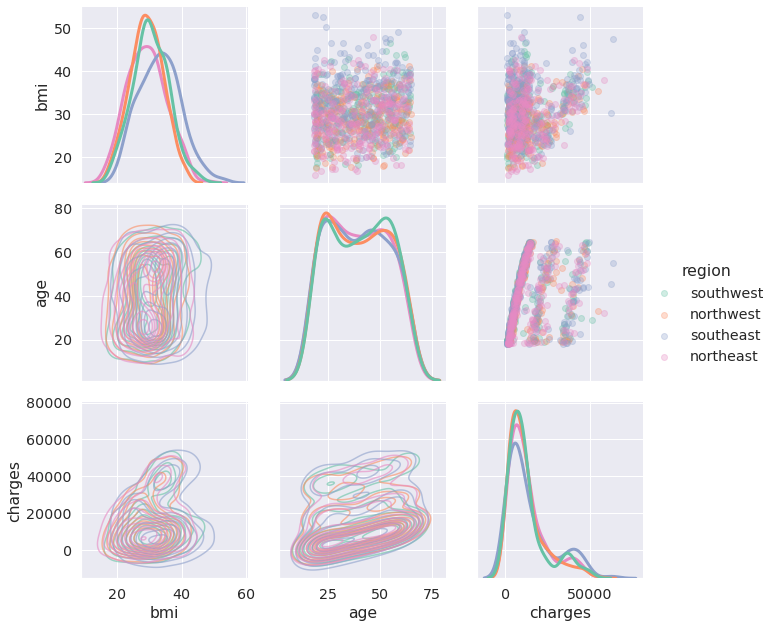

In [7]:
for hue in categorial_features:
    g = sns.PairGrid(train[['bmi', 'age', 'charges', hue]], 
                     hue=hue, diag_sharey=False, height=3)
    
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6, 
               common_norm=False)  # каждая плотность по отдельности должна давать 1 при интегрировании
    
    g.add_legend()

По графикам сразу можно сделать следующие выводы:
* расходы растут с увеличением возраста клиента;
* величина расходов больше для курящих людей.

Видимо, эти признаки должны оказать существенное влияние при построении регрессионной модели.

---

Далее **закодируем категориальные признаки** с помощью класса <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">`OneHotEncoder`</a>. Напомним, данный метод из одного категориального признака делает несколько бинарных признаков по количеству различных значений исходного категориального признака. Например, если исходный признак принимал 5 различных значений, то его кодировкой будет 5 новых бинарных признаков, где единица будет только у того бинарного признака, который соответствует данному значению исходного категориального признака. Иногда, *например, для линейной регрессии*, необходимо делать на один бинарный признак *меньше*, поскольку значения оставшегося бинарного признака можно выразить из значений всех остальных бинарных признаков.

**Важные аргументы конструктора:** 
* `categories` &mdash; если установлено значение `auto`, то категории определяются по имеющемуся объему данных, иначе, используется список категорий, который передается этим аргументом.
* `drop` &mdash; указывает методику, используемую для удаления одной из категорий для каждого объекта. Это может быть полезно для некоторых моделей, например, для линейной регрессии. Возможные значения указаны далее.
  * `None` &mdash; оставляем все признаки.
  * `'first'` &mdash; удаляет первую категорию для каждого признака. Если признак имеет одну категрию, то он будет удален полностью. 
  * `'if_binary'` &mdash; удаляет первую категорию только для бинарных признаков.
  * массив`drop`, где `drop[i]` &mdash; категория в признаке feature `X[:, i]`, которая должна быть удалена.
* `sparse` &mdash; возвращает sparse-матрицу, если установлено значение `True`, иначе &mdash; массив.

**Основные методы класса:**
* `fit(X)` &mdash; обучить кодировщик кодировать признаки на основе данных `X`. В данном случае под термином "обучить" поднимается определение функций кодирования и декодирования признаков.
* `transform(X)` &mdash; закодировать признаки в данных `X`.
* `fit_transform(X)` &mdash; обучить кодировщик по данным `X` и сразу их закодировать.
* `inverse_transform(X)` &mdash; декодировать признаки в данных `X`, то есть перевести бинарные признаки в исходные категориальные.

---

При построении кодировщика для наших данных учтем ряд особенностей:
* указываем `drop='first'`, то есть одну категорию нужно исключить;
* указываем `sparse=False`, то есть вернуть нужно неразреженную матрицу;
* нужно выполнить *обучение*, что в данном случае подразумевает построение и сохранение правила преобразования;
* сразу же кодируем признаки из обучающего множества;

In [8]:
encoder = OneHotEncoder(drop='first', sparse=False)  # объявляем модель
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_cat

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

Можем посмотреть на то, как у нас "обучились" категории. Для каждого категориального признака приведен список его категорий

In [9]:
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

Соединим вместе вещественные признаки и закодированные категориальные

In [10]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(1070, 8)

Наконец, **обучаем саму модель линейной регрессии** с помощью класса <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">`LinearRegression`</a>. 

**Важные аргументы конструктора:** 
* `fit_intercept` &mdash; нужно ли включать в модель свободный член. В случае `fit_intercept=True` модели не нужно передавать признак из всех единиц для того, чтобы она оценивала свободный член. По умолчанию `fit_intercept=True`.
* `normalize` &mdash; нужно ли сделать нормализацию данных. По умолчанию `fit_intercept=True`.

**Основные методы класса:**
* `fit(X, y)` &mdash; обучить линейную регрессию на основе данных `X` предсказывать целевой признак `y`. В данном случае под термином "обучить" поднимается вычисление оценки коэффициентов $\widehat{\theta}$.
* `predict(X)` &mdash; предсказать по данным `X` целевой признак `y`. В данном случае под термином "предсказать" поднимается вычисление оценки целевого признака $\widehat{y}$.

---

Теперь обучим модель линейной регрессии по нашим данным. Указываем `fit_intercept=True` для оценки свободного коэффициента, что позволяет не добавлять в матрицу признаков столбец из единиц.

*Замечание.* О нормализации данных пойдет речь в домашнем задании.

In [11]:
model = LinearRegression(fit_intercept=True)  # объявляем модель
model.fit(X_train, train[target_feature])  # обучаем

LinearRegression()

Посмотрим на результат обучения. Оценки коэффициентов перед признаками

In [12]:
model.coef_

array([  251.20626154,   354.16377059,   509.4681977 ,  -359.271869  ,
       23719.45592536,  -224.96919732, -1007.72585394,  -742.54332351])

Оценка свободного коэффициента

In [13]:
model.intercept_

-12311.432758825062

### 3. Тестирование и оценка качества

Выполним теперь с тестовым множеством данные те же преобразования. Напомним еще раз, что некоторые преобразования можно было сделать со всеми данными, это было бы корректно. Однако во избежании ошибок в будущем рекомендуем определять преобразования только по обучающим данным, а затем применять их для тестовых.

In [14]:
# Получаем возраст клиента по дате рождения
test['age'] = (pd.Timestamp('2021-04-17') - test['birthday']) / pd.Timedelta('1Y')

# Кодируем категориальные признаки с помощью метода transform обученного ранее кодировщика
test_cat = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_cat])

Выполним *предсказание* построенной ранее моделью с помощью метода `predict`

In [15]:
test_preds = model.predict(X_test)

Посчитать **ошибку предсказания** можно разными способами. Наиболее популярный способ &mdash; **метрика MSE** (*mean squared error*). Пусть $Y_1, ..., Y_n$ &mdash; истинные значения, а $\widehat{Y}_1, ..., \widehat{Y}_n$ &mdash; предсказания. Тогда метрика MSE определяется как
$$MSE = \frac{1}{n}\sum_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2.$$

*Замечание.* В анализе данных функционалы качества и функционалы ошибки предсказания принято называть метриками. Данные метрики не имеют никакого отношения к функциям расстояния, в качестве которых термин "метрика" используется в математическом анализе.

Посчитаем ее, а точнее &mdash; корень из нее, который еще обозначается как RMSE (*root MSE*)

In [16]:
np.sqrt(((test[target_feature] - test_preds) ** 2).mean())

6224.546349456895

Это значение уже имеет конкретный смысл  &mdash; насколько в среднем модель отклоняется от истинного значения. То есть в среднем отклонения предсказания величины страховых расходов имеют порядок 6 000 условных единиц. Напомним, что в данных страховые расходы в основной массе принимают значения до 50 000 у.е..

Готовая <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">реализация</a> также есть в `sklearn`:

In [17]:
metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5

6224.546349456895

Другой вариант &mdash; метрика **MAE** (*mean absolute error*), определяемая как 
$$MAE = \frac{1}{n}\sum_{i=1}^n \left|Y_i - \widehat{Y}_i\right|.$$

Ее большое преимущество в том, что она не сильно подстраивается по выбросы по сравнению с MSE. Однако ее труднее оптимизировать.

In [18]:
metrics.mean_absolute_error(test[target_feature], test_preds)

4427.349769931664

Еще один популярный вариант &mdash; метрика **MAPE** (*mean absolute percentage error*), определяемая как 
$$MAPE = 100\% \cdot \frac{1}{n}\sum_{i=1}^n \frac{\left|Y_i - \widehat{Y}_i\right|}{Y_i}.$$

В отличии от предыдущих метрик она позволяет посчитать ошибку *в процентах*, что бывает достаточно информативно в реальных задачах.

Реализуем ее

In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

Посчитаем для ее для наших данных

In [20]:
mean_absolute_percentage_error(test[target_feature], test_preds)

45.70285031479312

Для сравнения посчитаем предсказания и ошибки на обучающем множестве.

In [21]:
train_preds = model.predict(X_train)

metrics.mean_squared_error(train[target_feature], train_preds) ** 0.5, \
metrics.mean_absolute_error(train[target_feature], train_preds), \
mean_absolute_percentage_error(train[target_feature], train_preds)

(5997.755583853776, 4145.575949465933, 42.39590567710007)

Мы видим, что на обучающем множестве значения ошибок предсказания получились немного меньше, чем на тестовом множестве. Это и понятно, ведь наша модель так построена по обучающим данным, чтобы давать на них наименьшую ошибку. На данных, которые она "не видела" при обучении, она может вычислять предсказания несколько хуже. В этом и есть причина разделения данных на обучающую и тестовую часть.

Не редко случается так, что на обучающих данных модель ошибается гораздо меньше, чем на тестовых. Такую ситуацию еще называют **переобучением**. Простой пример &mdash; студент, который готовится к экзамену только за пару дней до него исключительно по билетам, не занимаясь при этом по предмету в течении семестра. Он может хорошо ответить по билетам на экзамене, ведь именно по ним он обучился. Однако, опыт показывает, что знания по каким-то другим вопросам оказываются значительно хуже, не говоря уже о применении полученных знаний в реальной практике.